In [1]:
import os
import numpy as np
np.seterr(all='print')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from matplotlib.animation import FuncAnimation

In [2]:
from matplotlib import rc
plt.style.use('seaborn')
rc('text', usetex=True)
%matplotlib inline

# Data preparation

## Data import

Load daily food log

In [3]:
food = pd.read_csv('food.csv', parse_dates=['date'])
food.head()

date                            name       type  quantity  units  \
0 2018-08-29               Egg, Fried, Large  Breakfast      50.0  Grams   
1 2018-08-29  Fish Ball, Asian Style, Cooked  Breakfast     153.0  Grams   
2 2018-08-29             Green Beans, Cooked  Breakfast      50.0  Grams   
3 2018-08-29      Soup, Egg Drop, Restaurant  Breakfast       3.0   Cups   
4 2018-08-29               Egg, Fried, Large      Lunch      50.0  Grams   

   calories   fat  protein   carb  saturated_fat  sugar  fiber  cholesterol  \
0        98  7.66     6.81   0.45           2.15   0.42   0.00       228.50   
1       116  1.22    18.82   6.88           0.31   2.14   0.00       110.16   
2        18  0.14     0.95   3.94           0.30   1.82   1.60         0.00   
3       195  4.41     8.39  31.20           1.16   0.65   2.89       166.29   
4        98  7.66     6.81   0.45           2.15   0.42   0.00       228.50   

   sodium  
0   102.0  
1   994.5  
2     0.5  
3  2675.1  
4   102.0

Load daily calories budget, steps, and logged weights

In [4]:
budget = pd.read_csv('budget.csv', parse_dates=['date'], index_col=0, squeeze=True)
steps = pd.read_csv('steps.csv', parse_dates=['date'], index_col=0, squeeze=True)
weights = pd.read_csv('weights.csv', parse_dates=['date'], index_col=0)

## Data transformation

Aggregate calories from food eaten during each day to get total calories consumed for that day

In [5]:
daily_cal = food.groupby('date')['calories'].sum()

For each day, find weight of the following day and record the weight gain from one day to the next (negative weight gain = weight loss)

In [6]:
weights['tomorrow_weight'] = weights.reindex(weights.index + pd.Timedelta(1, unit='D')).values
weights['weight_gain'] = weights['tomorrow_weight'] - weights['weight']

Merge daily calories consumed, budget calories, steps, and weight together, dropping rows with missing values

In [7]:
df = pd.concat([daily_cal, budget, steps, weights], axis=1).dropna()
df[['calories', 'budget', 'step']] = df[['calories', 'budget', 'step']].astype(int)

Calculate daily calories surplus (calories consumed beyond budget)

In [8]:
df['surplus'] = df['calories'] - df['budget']

# Exploratory Data Analysis

## Plots

Weights tend to fluctuate but shows general decrease during this time period

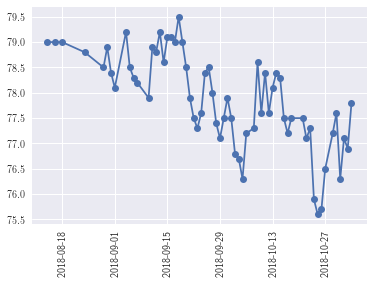

In [9]:
plt.plot(weights.index, weights['weight'].values, marker='o')
plt.xticks(rotation=90)
plt.show()

Among dates where the weight of the next date was recorded, 41.5% of them ended up in weight gain, 56.5% in weight loss, and the rest where weight did not change.

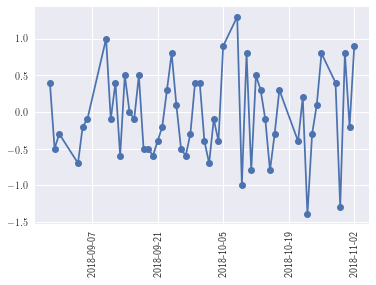

In [10]:
plt.plot(weights['weight_gain'].dropna().index, weights['weight_gain'].dropna().values, marker='o')
plt.xticks(rotation=90)
plt.show()

In [11]:
(weights['weight_gain'].dropna() > 0).mean(), (weights['weight_gain'].dropna() < 0).mean()

(0.41509433962264153, 0.5660377358490566)

However, among dates where relevant features (steps and calories consumed) are recorded, the proportion of dates with weight gain drops to 39%. This is not a huge class imbalance and so class imbalance treatments will not be used in this project.

In [12]:
(df['weight_gain'] > 0).mean()

0.391304347826087

Calories surplus over time

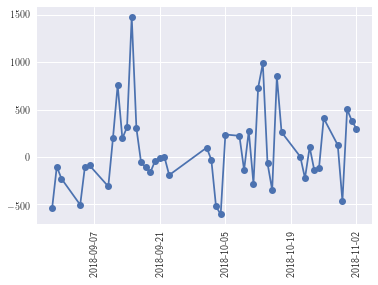

In [13]:
plt.plot(df.index, df['surplus'], marker='o')
plt.xticks(rotation=90)
plt.show()

Steps over time

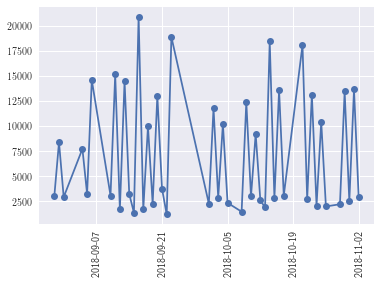

In [14]:
plt.plot(df.index, df['step'], marker='o')
plt.xticks(rotation=90)
plt.show()

Relationship between calories surplus and weight gain

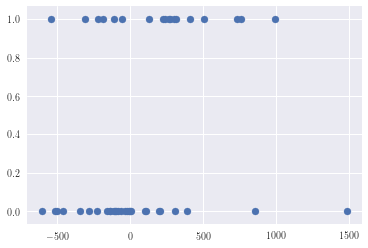

In [15]:
plt.scatter(df['surplus'], df['weight_gain'] > 0)
plt.show()

Relationship between steps and weight gain

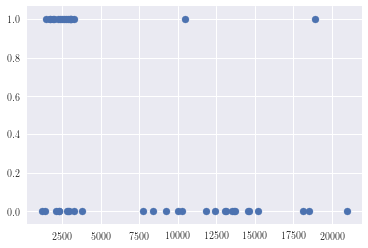

In [16]:
plt.scatter(df['step'], df['weight_gain'] > 0)
plt.show()

Plot weight gain status against 2-D representation of (calories surplus, steps)

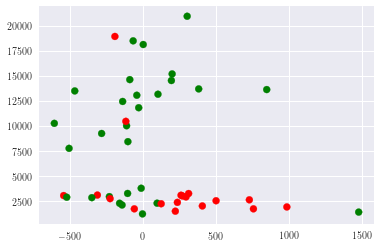

In [17]:
plt.scatter(df['surplus'], df['step'], color=list(np.where(df['weight_gain'] > 0, 'Red', 'Green')))
plt.show()

# Coding gradient ascent algorithm

## Prepare X & y matrices

In [18]:
X = df[['surplus', 'step']].values
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std
X = np.insert(X, 0, 1, axis=1)
X

array([[ 1.        , -1.48055187, -0.70860027],
       [ 1.        , -0.42058336,  0.20131366],
       [ 1.        , -0.72652882, -0.72635222],
       [ 1.        , -1.39141816,  0.08803935],
       [ 1.        , -0.4254014 , -0.67309639],
       [ 1.        , -0.38926611,  1.24817117],
       [ 1.        , -0.9240684 , -0.70014697],
       [ 1.        ,  0.30934951,  1.3438626 ],
       [ 1.        ,  1.65117329, -0.93278197],
       [ 1.        ,  0.29730441,  1.23244802],
       [ 1.        ,  0.58156869, -0.67427985],
       [ 1.        ,  3.38807624, -0.98772846],
       [ 1.        ,  0.5574785 ,  2.31751447],
       [ 1.        , -0.31458651, -0.93295104],
       [ 1.        , -0.44226453,  0.46945255],
       [ 1.        , -0.55789746, -0.83844307],
       [ 1.        , -0.27363318,  0.98425893],
       [ 1.        , -0.2013626 , -0.58535106],
       [ 1.        , -0.17968142, -1.0184985 ],
       [ 1.        , -0.63498608,  1.97650808],
       [ 1.        ,  0.06122051, -0.837

In [19]:
y = (df['weight_gain'] >= 0).values.astype(int)
y

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1])

## Build sigmoid function

In [20]:
def sigmoid(X, theta):
    """Return probability of y = 1 given an X matrix of m samples * n features, with first feature/column = 1;
    and a theta vectors of n features, with first feature = const.
    X: np.array (m * n)
    theta: np.array(n * 1)"""
    return 1 / (1 + np.exp(-X @ theta))

## Gradient Ascent Iteration(s)

### Single iteration

In [21]:
theta = np.array([0, 0, 0])
alpha = 0.01
lambda_reg = 10

In [22]:
prob = sigmoid(X, theta)
if np.all(prob != 0) or np.all(prob != 1):
    avg_log_likelihood = (y @ np.log(prob) + (1 - y) @ np.log(1 - prob)) / len(y)
    print(f'avg log likelihood: {avg_log_likelihood}')
reg_term = lambda_reg * theta
reg_term[0] = 0
gradient = (y - prob) @ X - reg_term
theta = theta + alpha * gradient
print(f'theta: {theta}')

avg log likelihood: -0.6931471805599453
theta: [-0.04        0.09088863 -0.1133165 ]


### Many iterations

In [23]:
theta = np.array([0., 0, 0])
alpha = 0.01
lambda_reg = 0

avg_log_likelihoods = []
for i in range(1000):
    prob = sigmoid(X, theta)
    if np.all(prob != 0) or np.all(prob != 1):
        avg_log_likelihood = (y @ np.log(prob) + (1 - y) @ np.log(1 - prob)) / len(y)
        avg_log_likelihoods.append(avg_log_likelihood)
    reg_term = lambda_reg * theta
    reg_term[0] = 0
    gradient = (y - prob) @ X - reg_term
    theta = theta + alpha * gradient

In [24]:
print(f'theta: {theta}')
print(f'predicted positive: {(prob > 0.5).sum()}')
print(f'avg log likelihood: {avg_log_likelihood}')
print(f'gradient: {gradient}')

theta: [-0.53601332  1.0052184  -1.34397147]
predicted positive: 19
avg log likelihood: -0.46496812529489756
gradient: [-5.55111512e-15  1.02140518e-14 -9.76996262e-15]


# Diagnostic plots

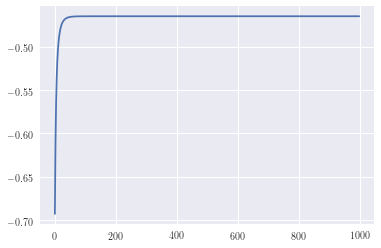

In [25]:
plt.plot(avg_log_likelihoods)
plt.show()

In [26]:
X1_mean, X1_std = df['surplus'].mean(), df['surplus'].std()
X2_mean, X2_std = df['step'].mean(), df['step'].std()

In [27]:
def plot_decision_boundary(ax, theta, **kwargs):   
    t0 = theta[0] - theta[1] * X1_mean / X1_std - theta[2] * X2_mean / X2_std
    t1 = theta[1] / X1_std
    t2 = theta[2] / X2_std
    ax.plot([-1000, 2000], (-t0 - np.array([-1000, 2000]) * t1) / t2, **kwargs)

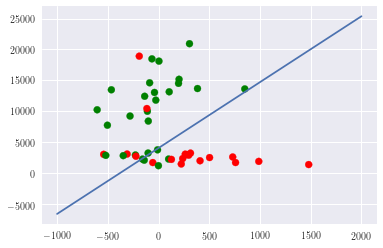

In [28]:
fig, ax = plt.subplots()
ax.scatter(df['surplus'], df['step'], color=list(np.where(y == 1, 'Red', 'Green')))
plot_decision_boundary(ax, theta)

# Encapsulate into class

In [29]:
class BatchLogistic:
    def __init__(self, theta, alpha, lambda_reg=0):
        self.theta = np.array(theta)
        self.alpha = alpha
        self.lambda_reg = lambda_reg
        
    def sigmoid(self, X, theta):
        return 1 / (1 + np.exp(-X @ theta))
    
    def fit(self, X, y, n_iter):
        self.avg_log_likelihoods = []
        self.thetas = []
        self.objectives = []
        
        for i in range(n_iter):
            self.thetas.append(self.theta)
            prob = self.sigmoid(X, self.theta)
            if np.all(prob != 0) or np.all(prob != 1):
                self.avg_log_likelihood = (y @ np.log(prob) + (1 - y) @ np.log(1 - prob)) / len(y)
                self.objective = self.avg_log_likelihood + self.lambda_reg * self.theta @ self.theta
                self.avg_log_likelihoods.append(self.avg_log_likelihood)
                self.objectives.append(self.objective)
            reg_term = self.lambda_reg * self.theta
            reg_term[0] = 0
            self.gradient = (y - prob) @ X - reg_term
            self.theta = self.theta + self.alpha * self.gradient
        self.last_avg_log_likelihood_diff = self.avg_log_likelihoods[-1] - self.avg_log_likelihoods[-2]
        self.thetas = np.array(self.thetas)
            
    def predict(self, X, threshold=0.5):
        return (self.sigmoid(X, self.theta) > threshold).astype(int)
    
    def predict_proba(self, X):
        return self.sigmoid(X, self.theta)

# Visualize convergence of batch logistic regression

## Unpenalized

In [30]:
log0 = BatchLogistic(theta=[0.5, 0.5, 0.5], alpha=0.01, lambda_reg=0)
log0.fit(X, y, n_iter=61)
log0.theta

array([-0.48900269,  0.97758258, -1.26142909])

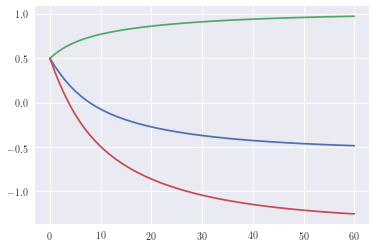

In [31]:
plt.plot(log0.thetas)
plt.show()

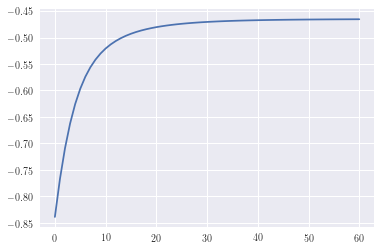

In [32]:
plt.plot(log0.avg_log_likelihoods)
plt.show()

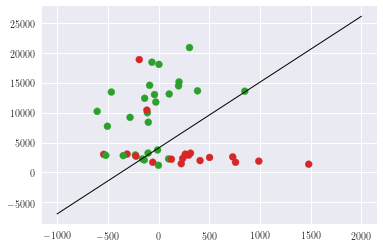

In [33]:
fig, ax = plt.subplots()
ax.scatter(df['surplus'], df['step'], color=list(np.where(y == 1, 'tab:red', 'tab:green')))
plot_decision_boundary(ax, log0.theta, color='black', linewidth=1)

## Animate convergence of coefficients, log likelihood, and decision boundary

In [34]:
def setup_anim(df):
    fig = plt.figure(figsize=(20, 5))
    fig.subplots_adjust(left=0.05, right=0.95)

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_xlim(0, 60)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_xlabel('Iteration', fontsize=15)
    ax1.set_ylabel(r'$\theta$', fontsize=15)

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_xlim(0, 60)
    ax2.set_ylim(-0.9, -0.3)
    ax2.set_xlabel('Iteration', fontsize=15)
    ax2.set_ylabel('Average Log Likelihood', fontsize=15)

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.set_xlim(-1000, 2000)
    ax3.set_ylim(-5000, 25000)
    ax3.set_xlabel(r'Calories', fontsize=15)
    ax3.set_ylabel(r'Steps', fontsize=15)
    ax3.scatter(df['surplus'], df['step'], color=list(np.where(y == 1, 'tab:red', 'tab:green')))
    return fig, ax1, ax2, ax3

In [35]:
def update(i, fig, ax1, ax2, ax3, log, existing=False):
    if log.lambda_reg:
        suptitle = rf'$Iteration\ {i}\ (\alpha={log.alpha}, \lambda={log.lambda_reg})$'
    else:
        suptitle = rf'$Iteration\ {i}\ (\alpha={log.alpha})$'
    fig.suptitle(suptitle, fontsize=20)
    
    ax1.plot(range(i, i+2), log.thetas[i:i+2, 0], color='tab:blue')
    ax1.plot(range(i, i+2), log.thetas[i:i+2, 1], color='tab:cyan')
    ax1.plot(range(i, i+2), log.thetas[i:i+2, 2], color='tab:purple')
    if i == 0:
        ax1.legend(iter(ax1.lines[3:]), [r'$\theta_{Intercept}$', r'$\theta_{Surplus}$', r'$\theta_{Step}$'], 
                   loc='upper left', fontsize=12, frameon=True, framealpha=1,
                   facecolor='white', edgecolor='black', labelspacing=0.1)
    
    ax2.plot(range(i, i+2), log.avg_log_likelihoods[i:i+2], color='black', linewidth=1)

    if existing:
        if len(ax3.lines) > 1:
            ax3.lines = [ax3.lines[0]]
    else:
        if len(ax3.lines) == 1:
            ax3.lines = []
    plot_decision_boundary(ax3, log.thetas[i], color='black', linewidth=1)

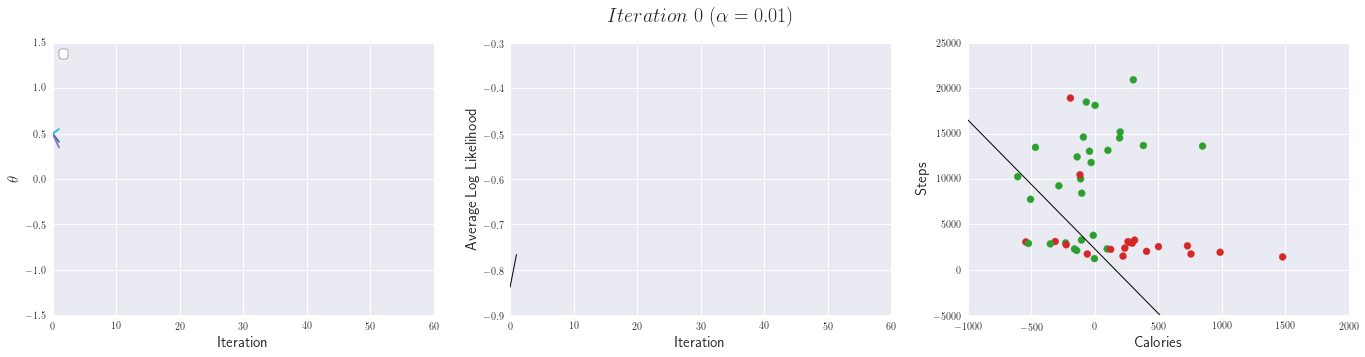

In [36]:
fig_0, ax1_0, ax2_0, ax3_0 = setup_anim(df)
anim_0 = FuncAnimation(fig_0, lambda i: update(i, fig_0, ax1_0, ax2_0, ax3_0, log0), 
                     frames=range(len(log0.thetas)-1), interval=100, repeat=True)

In [1250]:
anim_0.save('log0.gif', writer='imagemagick')

## Animate convergence of L2-regularized logistic regresssion with lambda = 10

In [37]:
log0_1000 = BatchLogistic(theta=[0.5, 0.5, 0.5], alpha=0.01, lambda_reg=0)
log0_1000.fit(X, y, n_iter=1000)
log0_1000.last_avg_log_likelihood_diff, log0_1000.theta

(0.0, array([-0.53601332,  1.0052184 , -1.34397147]))

In [38]:
log10 = BatchLogistic(theta=[0.5, 0.5, 0.5], alpha=0.01, lambda_reg=10)
log10.fit(X, y, n_iter=61)
log10.theta

array([-0.38546622,  0.40245169, -0.5299052 ])

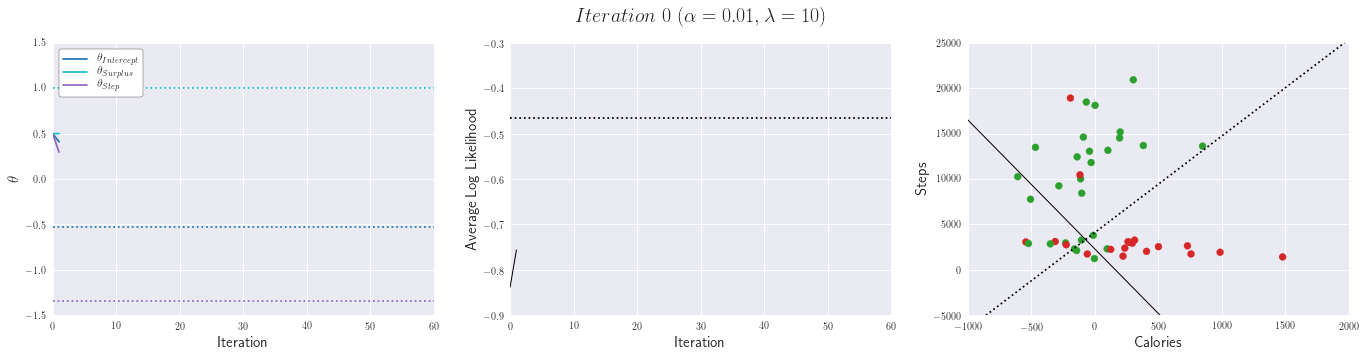

In [39]:
fig_10, ax1_10, ax2_10, ax3_10 = setup_anim(df)
ax1_10.axhline(log0_1000.theta[0], color='tab:blue', linestyle=':')
ax1_10.axhline(log0_1000.theta[1], color='tab:cyan', linestyle=':')
ax1_10.axhline(log0_1000.theta[2], color='tab:purple', linestyle=':')
ax2_10.axhline(log0_1000.avg_log_likelihood, color='black', linestyle=':')
plot_decision_boundary(ax3_10, log0_1000.theta, color='black', linestyle=':')

anim10 = FuncAnimation(fig_10, lambda i: update(i, fig_10, ax1_10, ax2_10, ax3_10, log10, existing=True), 
                     frames=range(len(log10.thetas)-1), interval=100, repeat=True)

In [1254]:
anim10.save('log10.gif', writer='imagemagick')

# Plot regression coefficients for different degrees of L2-regularization

In [77]:
thetas = []
lambda_regs = [0, 1, 10, 100]
for lambda_reg in lambda_regs:
    log = BatchLogistic(theta=[0, 0, 0], alpha=0.001, lambda_reg=lambda_reg)
    log.fit(X, y, n_iter=1000)
    thetas.append(log.theta)
thetas = np.array(thetas)

In [78]:
log100_1000 = BatchLogistic(theta=[0.5, 0.5, 0.5], alpha=0.01, lambda_reg=100)
log100_1000.fit(X, y, n_iter=1000)
log100_1000.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

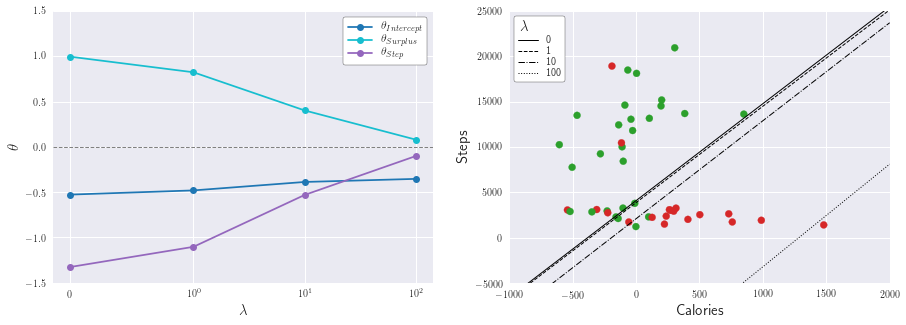

In [156]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlabel(r'$\lambda$', fontsize=15)
ax1.set_ylabel(r'$\theta$', fontsize=15)
ax1.set_xticks([0, 1])
ax1.plot(lambda_regs, thetas[:, 0], 'o-', color='tab:blue', label=r'$\theta_{Intercept}$')
ax1.plot(lambda_regs, thetas[:, 1], 'o-', color='tab:cyan', label=r'$\theta_{Surplus}$')
ax1.plot(lambda_regs, thetas[:, 2], 'o-', color='tab:purple', label=r'$\theta_{Step}$')
ax1.axhline(0, linestyle='--', linewidth=1, color='gray')
ax1.legend(fontsize=12, frameon=True, framealpha=1, facecolor='white', edgecolor='black', labelspacing=0.1)
ax1.set_xscale('symlog', linthreshx=1)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(-1000, 2000)
ax2.set_ylim(-5000, 25000)
ax2.set_xlabel(r'Calories', fontsize=15)
ax2.set_ylabel(r'Steps', fontsize=15)
ax2.scatter(df['surplus'], df['step'], color=list(np.where(y == 1, 'tab:red', 'tab:green')), label='_nolegend_')
for i, (lambda_reg, linestyle) in enumerate(zip(lambda_regs, ['-', '--', '-.', ':'])):
    plot_decision_boundary(ax2, thetas[i], color='black', linestyle=linestyle, linewidth=1, label=lambda_reg)
ax2.legend(title="$\lambda$", frameon=True, framealpha=1, facecolor='white', edgecolor='black', labelspacing=0.1)
ax2.get_legend().get_title().set_fontsize(15)
ax2.get_legend().get_title().set_position((-15, 0))

# Compare with sklearn's SGDClassifier

In [793]:
from sklearn.linear_model import SGDClassifier

In [1560]:
log = SGDClassifier(loss='log', penalty='l2', alpha=0, 
                    learning_rate='constant', eta0=0.01,
                    random_state=42, max_iter=1000)
# log = LogisticRegression(penalty='l2', C=0.000001, random_state=42)

log.fit(X[:, 1:], y)
log.intercept_, log.coef_

(array([-0.53799625]), array([[ 1.00531811, -1.34598834]]))